In [ ]:
!pip install tensorflow keras numpy matplotlib opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to train and validation data
train_image_dir = '/content/drive/MyDrive/yolov11/dataset/images/train'
train_mask_dir = '/content/drive/MyDrive/yolov11/dataset/masks/train'
val_image_dir = '/content/drive/MyDrive/yolov11/dataset/images/val'
val_mask_dir = '/content/drive/MyDrive/yolov11/dataset/masks/val'


In [ ]:
# Load images and masks
def load_data(image_dir, mask_dir, target_size=(320, 320)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        # Load and preprocess images
        image = cv2.imread(img_path)
        image = cv2.resize(image, target_size) / 255.0  # Normalize
        images.append(image)

        # Load and preprocess masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size) / 255.0  # Normalize
        masks.append(mask)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

# Paths to train and validation data
train_image_dir = '/content/drive/MyDrive/yolov11/dataset/images/train'
train_mask_dir = '/content/drive/MyDrive/yolov11/dataset/masks/train'
val_image_dir = '/content/drive/MyDrive/yolov11/dataset/images/val'
val_mask_dir = '/content/drive/MyDrive/yolov11/dataset/masks/val'

# Load training and validation data
X_train, Y_train = load_data(train_image_dir, train_mask_dir)
X_val, Y_val = load_data(val_image_dir, val_mask_dir)


In [ ]:
print("Training data shapes:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print("Validation data shapes:")
print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")


Training data shapes:
X_train: (2021, 320, 320, 3), Y_train: (2021, 320, 320, 1)
Validation data shapes:
X_val: (578, 320, 320, 3), Y_val: (578, 320, 320, 1)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import os
import cv2
import numpy as np

def data_generator(image_dir, mask_dir, batch_size):
    images = os.listdir(image_dir)
    while True:
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i+batch_size]
            X_batch = []
            Y_batch = []
            for img_name in batch_images:
                img_path = os.path.join(image_dir, img_name)
                mask_path = os.path.join(mask_dir, img_name)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (320, 320)) / 255.0
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (320, 320)) / 255.0
                X_batch.append(image)
                Y_batch.append(np.expand_dims(mask, axis=-1))
            yield np.array(X_batch), np.array(Y_batch)


# U-Net Definition
def build_unet(input_shape):
    inputs = Input(input_shape)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    u4 = UpSampling2D((2, 2))(c3)
    u4 = Concatenate()([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (320, 320, 3)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data generator function (as before)
batch_size = 4
train_gen = data_generator(train_image_dir, train_mask_dir, batch_size)
val_gen = data_generator(val_image_dir, val_mask_dir, batch_size)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(os.listdir(train_image_dir)) // batch_size,
    validation_steps=len(os.listdir(val_image_dir)) // batch_size,
    epochs=10
)


Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 163s 269ms/step - accuracy: 0.9790 - loss: 0.0406 - val_accuracy: 0.9921 - val_loss: 0.0146
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 129s 232ms/step - accuracy: 0.9925 - loss: 0.0091 - val_accuracy: 0.9914 - val_loss: 0.0122
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 113s 225ms/step - accuracy: 0.9927 - loss: 0.0055 - val_accuracy: 0.9930 - val_loss: 0.0066
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 113s 224ms/step - accuracy: 0.9928 - loss: 0.0035 - val_accuracy: 0.9931 - val_loss: 0.0058
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 113s 223ms/step - accuracy: 0.9928 - loss: 0.0031 - val_accuracy: 0.9932 - val_loss: 0.0041
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 112s 222ms/step - accuracy: 0.9928 - loss: 0.0029 - val_accuracy: 0.9932 - val_loss: 0.0033
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 111s 220ms/step - accuracy: 0.9928 - loss: 0.0028 - val_accuracy: 0.9931 - val_loss: 0.0035
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 111s 220ms/step - accuracy: 0.9928 -

In [ ]:
model.save('unet_fish_segmentation.h5')


In [ ]:

# Save the model to your Drive
model.save('/content/drive/MyDrive/unet_fish_segmentation.h5')


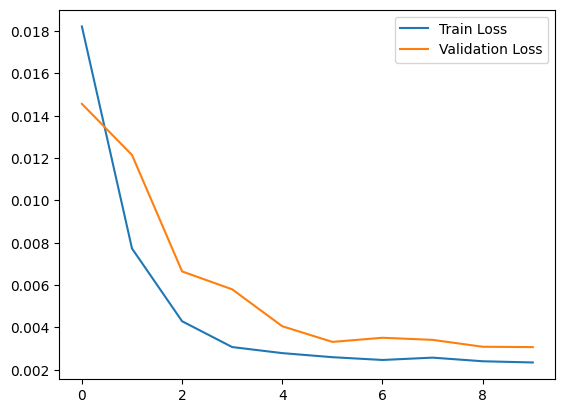

In [ ]:
# Load history
with open('/content/training_history.json', 'r') as f:
    history = json.load(f)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.9934 - loss: 0.0032
Validation Loss: 0.0030726417899131775, Validation Accuracy: 0.9932059049606323
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 401ms/step


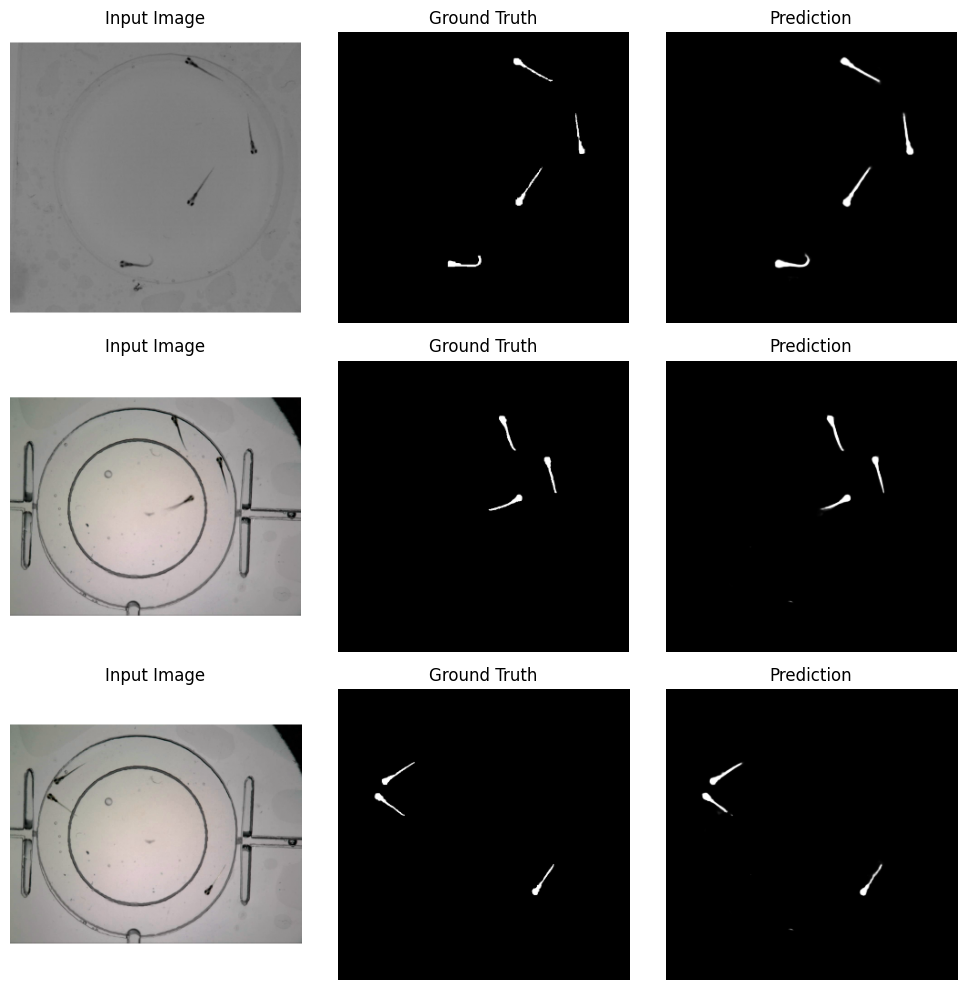

In [ ]:
# Ensure validation data and model are loaded
# Assuming `model`, `X_val`, and `Y_val` are available from earlier

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

# Function to visualize predictions
def visualize_predictions(model, X, Y):
    predictions = model.predict(X)  # Predict using the trained model
    plt.figure(figsize=(10, 10))
    for i in range(3):  # Display 3 samples
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(X[i])
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on the validation data
visualize_predictions(model, X_val, Y_val)


In [ ]:
!pip install opencv-python ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 14.5 MB/s eta 0:00:00


In [ ]:
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the loaded model
unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model

# Load YOLOv11 and U-Net models
yolo_model = YOLO('/content/drive/MyDrive/yolov9/runs/experiment_original2/weights/best.pt')
unet_model = load_model('/content/drive/MyDrive/unet_fish_segmentation.h5')

# Directories
test_image_dir = '/content/drive/MyDrive/yolov11/dataset/images/test'  # Path to test images
output_dir = '/content/drive/MyDrive/yolov11/results/'  # Path to save results
os.makedirs(output_dir, exist_ok=True)

# Process each image in the test dataset
for image_file in os.listdir(test_image_dir):
    image_path = os.path.join(test_image_dir, image_file)
    image = cv2.imread(image_path)

    # YOLOv11 Detection
    results = yolo_model(image)
    detections = results[0].boxes.data.cpu().numpy()  # Convert detections to NumPy format

    for i, detection in enumerate(detections):
        x_min, y_min, x_max, y_max, confidence, cls = detection

        # Crop region
        cropped_region = image[int(y_min):int(y_max), int(x_min):int(x_max)]

        # U-Net Segmentation
        cropped_resized = cv2.resize(cropped_region, (320, 320)) / 255.0  # Normalize
        cropped_resized = np.expand_dims(cropped_resized, axis=0)  # Add batch dimension
        mask = unet_model.predict(cropped_resized)[0].squeeze()  # Predict mask
        mask = (mask > 0.5).astype(np.uint8)  # Threshold mask

        # Resize mask to original crop size for better visualization
        mask_resized = cv2.resize(mask, (cropped_region.shape[1], cropped_region.shape[0]))

        # Combine mask and original image (optional visualization)
        combined = cropped_region.copy()
        combined[mask_resized == 1] = [0, 255, 0]  # Overlay mask in green

        # Save or visualize results
        output_path_mask = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_bbox_{i}_mask.png")
        output_path_combined = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_bbox_{i}_combined.png")

        cv2.imwrite(output_path_mask, mask_resized * 255)  # Save mask as an image
        cv2.imwrite(output_path_combined, combined)  # Save combined visualization



0: 640x640 1 fish_larvae, 10.2ms
Speed: 6.4ms preprocess, 10.2ms inference, 917.3ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

0: 640x640 1 fish_larvae, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

0: 640x640 3 fish_larvaes, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

0: 640x640 4 fish_larvaes, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

0: 640x640 1 fish_larvae, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to the U-Net segmentation predictions and ground truth masks
unet_segmentation_path = "/content/drive/MyDrive/yolov11/predictions/"

In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray

# Paths to the U-Net segmentation results and ground truth masks
unet_segmentation_path = "/content/drive/MyDrive/yolov11/predictions/"
gt_path = "/content/drive/MyDrive/yolov11/unet_GT/"

# Initialize accumulators for metrics
iou_list = []
dice_list = []
pixel_acc_list = []

def calculate_iou_segmentation(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return (intersection / union * 100) if union != 0 else 0

def calculate_dice(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    return (2 * intersection / (pred_mask.sum() + gt_mask.sum()) * 100) if (pred_mask.sum() + gt_mask.sum()) != 0 else 0

def calculate_pixel_accuracy(pred_mask, gt_mask):
    correct_pixels = (pred_mask == gt_mask).sum()
    total_pixels = gt_mask.size
    return (correct_pixels / total_pixels * 100)

def evaluate_segmentation(pred_mask, gt_mask):
    iou = calculate_iou_segmentation(pred_mask, gt_mask)
    dice = calculate_dice(pred_mask, gt_mask)
    pixel_acc = calculate_pixel_accuracy(pred_mask, gt_mask)
    return iou, dice, pixel_acc

# Set the split to "test" only
split = "test"
split_pred_path = os.path.join(unet_segmentation_path, split)
split_gt_path = os.path.join(gt_path, split)

if not os.path.exists(split_pred_path):
    print(f"Prediction folder for {split} does not exist.")
else:
    if not os.path.exists(split_gt_path):
        print(f"Ground truth folder for {split} does not exist.")
    else:
        # Loop through all files in the test split
        for filename in os.listdir(split_pred_path):
            if filename.endswith(".png"):  # Ensure the file is a .png mask
                # Predicted mask (U-Net segmentation result)
                pred_mask_path = os.path.join(split_pred_path, filename)
                pred_mask = imread(pred_mask_path)
                if pred_mask.ndim == 3:  # If the mask has 3 channels (RGB)
                    pred_mask = rgb2gray(pred_mask)
                pred_mask = pred_mask > 0.5  # Convert to binary mask

                # Corresponding ground truth mask
                gt_mask_path = os.path.join(split_gt_path, filename)

                if os.path.exists(gt_mask_path):  # Ensure the ground truth mask exists
                    gt_mask = imread(gt_mask_path)
                    if gt_mask.ndim == 3:  # If the mask has 3 channels (RGB)
                        gt_mask = rgb2gray(gt_mask)
                    gt_mask = gt_mask > 0.5  # Convert to binary mask

                    # Evaluate segmentation
                    iou, dice, pixel_acc = evaluate_segmentation(pred_mask, gt_mask)

                    # Store metrics
                    iou_list.append(iou)
                    dice_list.append(dice)
                    pixel_acc_list.append(pixel_acc)
                else:
                    print(f"Ground truth mask not found for: {filename} in {split} split.")

# Calculate and display average metrics
if iou_list:
    avg_iou = np.mean(iou_list)
    avg_dice = np.mean(dice_list)
    avg_pixel_acc = np.mean(pixel_acc_list)

    print(f"U-Net Segmentation Results (Test Dataset):")
    print(f"Average IoU: {avg_iou:.2f}%")
    print(f"Average Dice Coefficient: {avg_dice:.2f}%")
    print(f"Average Pixel Accuracy: {avg_pixel_acc:.2f}%")
else:
    print("No valid image pairs found for evaluation in the test dataset.")


U-Net Segmentation Results (Test Dataset):
Average IoU: 39.41%
Average Dice Coefficient: 55.64%
Average Pixel Accuracy: 99.42%
